In [44]:
from sklearn.manifold import TSNE 
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [45]:
import datasets as datasets
import datasets.cub200 as cub200
import architectures as archs
import os, sys, numpy as np, argparse, imp, datetime, pandas as pd, copy
import time, pickle as pkl, random, json, collections
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

from tqdm import tqdm

import parameters    as par

## Read argument

In [62]:
args = argparse.Namespace(
    loss="margin",
    batch_mining="distance",
    log_online=True,
    project="DML_project",
    group="cub200lt",
    seed=0,
    gpu=7,
    bs=112,
    data_sampler="class_random",
    samples_per_class=2,
    arch="resnet50_frozen_normalize",
    source="/hdd/hdd3/kjb/dataset",
    n_epochs=150,
    lr=0.00001,
    embed_dim=128,
    evaluate_on_gpu=True,
    imb_factor=0.5,
    savename="test"
)

In [63]:
################### INPUT ARGUMENTS ###################
parser = argparse.ArgumentParser()

parser = par.basic_training_parameters(parser)
parser = par.batch_creation_parameters(parser)
parser = par.batchmining_specific_parameters(parser)
parser = par.loss_specific_parameters(parser)
parser = par.wandb_parameters(parser)

##### Read in parameters
opt = parser.parse_args(args=[])

## Load dataset

In [64]:
datasets = cub200.Give(opt, '/hdd/hdd3/kjb/dataset/cub200')
dataloaders = {}
dataloaders['testing'] = torch.utils.data.DataLoader(datasets['testing'],  num_workers=6, batch_size=112, shuffle=False)

spliting test data into [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10] number of datasets
spliting train data into [50, 50, 50, 50, 44, 41, 50, 48, 50, 50, 50, 50, 50, 50, 50, 50, 50, 45, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50

## Create model

In [65]:
model      = archs.select('resnet50_frozen_normalize', opt)
model = model.to(device)
model.eval()

Network(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Load model

In [70]:
ckpt = torch.load('/home/lyj/cv2023_image_retrieval/checkpoints/model_epoch_50_if_0.5.pth')
model.load_state_dict(ckpt)

<All keys matched successfully>

## create tsne plot tool

[  0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1
   1   1   2   2   2   2   2   2   2   2   2   2   3   3   3   3   3   3
   3   3   3   3   4   4   4   4   4   4   4   4   4   4   5   5   5   5
   5   5   5   5   5   5   6   6   6   6   6   6   6   6   6   6   7   7
   7   7   7   7   7   7   7   7   8   8   8   8   8   8   8   8   8   8
   9   9   9   9   9   9   9   9   9   9 190 190 190 190 190 190 190 190
 190 190 191 191 191 191 191 191 191 191 191 191 192 192 192 192 192 192
 192 192 192 192 193 193 193 193 193 193 193 193 193 193 194 194 194 194
 194 194 194 194 194 194 195 195 195 195 195 195 195 195 195 195 196 196
 196 196 196 196 196 196 196 196 197 197 197 197 197 197 197 197 197 197
 198 198 198 198 198 198 198 198 198 198 199 199 199 199 199 199 199 199
 199 199]


/home/lyj/.conda/envs/cv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/lyj/.conda/envs/cv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


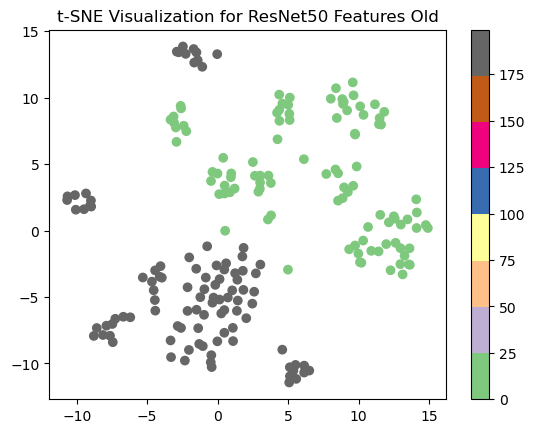

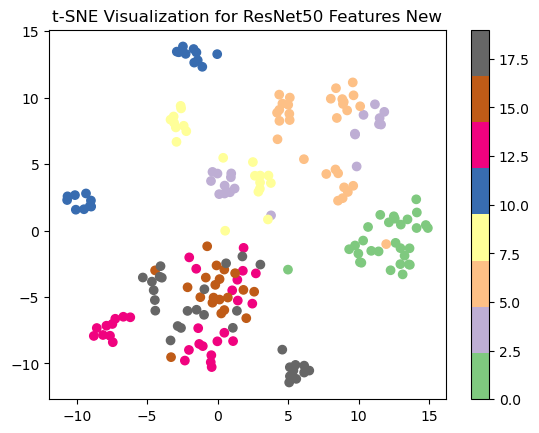

In [123]:
from sklearn.preprocessing import LabelEncoder

model.eval() 
all_features = []
all_labels = []
%matplotlib inline
with torch.no_grad():
    for data in dataloaders['testing']:
        # label, feature: (b, c, 224, 224)
        labels, images = data[0].to(device), data[1].to(device)
        
        features =  list(model(images)[1])[0] # (batch, 2048)
        
        # Append features and labels to lists
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        
# Concatenate features and labels
features = np.concatenate(all_features, axis=0)
labels = np.concatenate(all_labels, axis=0)

features = np.concatenate([features[:100, :], features[-100:, :]], axis=0)
labels = np.concatenate([labels[:100], labels[-100:]], axis=0)
print(labels)

# Use LabelEncoder to renumber the classes
label_encoder = LabelEncoder()
labels_renumbered = label_encoder.fit_transform(labels)


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features)



# Plot the old t-SNE results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='Accent')
plt.title('t-SNE Visualization for ResNet50 Features Old')
plt.colorbar()
plt.show()

# Plot the t-SNE results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_renumbered, cmap='Accent')
plt.title('t-SNE Visualization for ResNet50 Features New')
plt.colorbar()
plt.show()